In [3]:
import numpy as np
from io import StringIO
import time,os, importlib
from tqdm import tqdm
np.set_printoptions(linewidth=160)
import lib.ktn_io as kio
import lib.gt_tools as gt
from scipy.sparse import save_npz,load_npz, diags, eye, csr_matrix,bmat
from scipy.sparse.linalg import eigs,inv,spsolve
from scipy.sparse.csgraph import connected_components
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set()
%matplotlib inline

Using tqdm package for pretty progress bars!


# Example - load in full matrix, perform partial GT

In [14]:
# index_sel = which states in data file are part of largest connected component and hence are included in KTN

# only states where index_sel = True feature in K,D,B etc. i.e. N = index_sel.sum()

# B: braching prob, K = rates, D = total rate per state, u = energy, s = entropy, Emin = min E, 

data_path = "KTN_data/LJ38/4k/"
temp = 100.
beta = 1./temp
B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=True)
#non-csr matrix version of D:
D = np.ravel(K.sum(axis=0)) 
#free energy of minima
BF = beta*u-s
#rescaled
BF -= BF.min()
# AB regions
AS,BS = kio.load_AB(data_path,index_sel)
print(f'Num in A: {AS.sum()}')
print(f'Num in B: {BS.sum()}')
print(f'Num in I: {index_sel.sum() - AS.sum() - BS.sum()}')

Connected Clusters: 1620, 1st 400 states in largest cluster: 0
cc: N: 4000->900 (4000,) (4000,)
Num in A: 5
Num in B: 128
Num in I: 767


States to eliminate: 690
210
Retained B states: 128
(82,)
(82,)
188214.37270593824
188214.37268881607
0.989467710310425


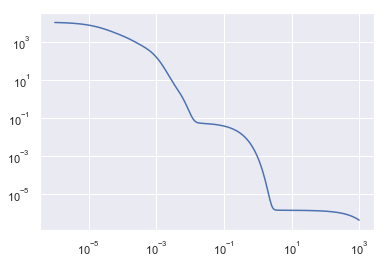

In [27]:
# select states not in A,B AND not in the lowest 10% free energy of states not in A,B
rm_reg = np.zeros(N,bool)
#set top 90% of I states in terms of free energy to True
rm_reg[~(AS+BS)] = BF[~(AS+BS)]>np.percentile(BF[~(AS+BS)],10.0)
print(f'States to eliminate: {rm_reg.sum()}')
# retained states are selected by the NOT of this vector, i.e. ~rm_reg --> 
# all A, all B, and lowest 10% of free energy states in I

# negative reduced rate matrix (i.e. K-D)
GT_Q = gt.gt_seq(N=N,rm_reg=rm_reg,B=B,D=D,trmb=10,retK=True,Ndense=50,screen=False)[2]

# Reduced Boltzmann in A
rho = (np.exp(-BF) * AS)[~rm_reg] / (np.exp(-BF) * AS).sum()
print(rho.size)
# select states in B (same as BS since we're keeping all in A and B right now)
RBS = BS[~rm_reg]
print(f'Retained B states: {RBS.sum()}')

#rate matrix for I U A --- B is absorbing
Q = GT_Q[:,~RBS][~RBS,:] # block NOT in B - this is an absorbing matrix which we diagonalize to get pdf etc

# first moment tau(A->B) = 1.Q^{-1}.rho(A) = 1.x
x = spsolve(Q,rho[~RBS])
tau = x.sum()

# Second moment = 2 x 1.Q^{-2}.rho = 2.0* 1.Q^{-1}.x
y = spsolve(Q,x)
tau_sq =  2.0*y.sum()


# pdf
pt = np.zeros((2,400))
#time in multiples of the mean first passage time
pt[0] = np.logspace(-6,3,pt.shape[1])*tau
#nu=eigenvalues, v=left eigenvectors, w=right eigenvectors
nu,v,w = spla.eig(Q.todense(),left=True)
#some sort of normalization factor?
dp = np.sqrt(np.diagonal(w.T.dot(v))).real
#dot product between v and P(0)=rho
v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~RBS])
print(v.shape)
w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
print(w.shape)
nu = nu.real
#(v*w/nu).sum() is the first moment <tau>
print(tau)
print((v*w/nu).sum())
# this bit is p(t), and its integral is 1 so it's normalized
pdf = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))
print(sp.integrate.simps(pdf, pt[0]))
#so this is p(factor*<tau>) * <tau>
pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()


plt.loglog(pt[0]/tau,pt[1])

array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

# Ways to Select Nodes to Eliminate

In [207]:
params = {'axes.edgecolor': 'black', 'axes.facecolor':'white', 'axes.grid': True, 'axes.titlesize': 16.0,
          'axes.linewidth': 0.75, 'backend': 'pdf','axes.labelsize':
          14,'legend.fontsize': 12,
          'xtick.labelsize': 11,'ytick.labelsize': 11,'text.usetex':
          False,'figure.figsize': [7, 5],
          #'font.family': 'serif', 'font.serif': 'Computer Modern Roman',
          'mathtext.fontset': 'cm', 'savefig.format': 'pdf',
          'xtick.bottom':True, 'xtick.major.pad': 5, 'xtick.major.size': 5,
          'xtick.major.width': 0.5,
          'ytick.left':True, 'ytick.right':False, 'ytick.major.pad': 5,
          'ytick.major.size': 5, 'ytick.major.width': 0.5,
          'ytick.minor.right':False, 'lines.linewidth':2}
plt.rcParams.update(params)

In [26]:
#Attempt to rank nodes based on free energy, escape time, node degree, and see what we get
def rank_nodes_to_eliminate(beta=1.0/0.25, escape_time_upper_bound=1000):
    Nmax = None
    data_path = "KTN_data/LJ38/4k"
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=Nmax,screen=False)
    D = np.ravel(K.sum(axis=0)) #array of size (N,) containing escape rates for each min
    BF = beta*u-s
    BF -= BF.min()
    escape_times = 1.0/D
    node_degree = B.indptr[1:] - B.indptr[:-1]
    print(f'Number of nodes with >1 connection: {len(node_degree[node_degree > 1])}')
    AS,BS = kio.load_AB(data_path,index_sel)
    IS = np.zeros(N, bool)
    IS[~(AS+BS)] = True
    print(f'A: {AS.sum()}, B: {BS.sum()}, I: {IS.sum()}')
    
    fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(15,4))
    colors = sns.color_palette("Paired")
    #node degree vs escape time
    ax.scatter(node_degree[IS], escape_times[IS], color=colors[8], alpha=0.4, label='I')
    ax.scatter(node_degree[AS], escape_times[AS], color=colors[5], alpha=0.8, label='A')
    ax.scatter(node_degree[BS], escape_times[BS], color=colors[1], alpha=0.4, label='B')
    ax.set_xlabel('Node Degree')
    ax.set_ylabel('Escape Time')
    #ax.set_yscale('log')
    ax.set_ylim([-1.0, escape_time_upper_bound])
    ax.legend()
    #free energy vs escape time
    ax1.scatter(BF[IS], escape_times[IS], color=colors[8], alpha=0.4, label='I')
    ax1.scatter(BF[AS], escape_times[AS], color=colors[5], alpha=0.8, label='A')
    ax1.scatter(BF[BS], escape_times[BS], color=colors[1], alpha=0.4, label='B')
    ax1.set_xlabel('Free Energy')
    ax1.set_ylabel('Escape Time')
    #ax1.set_yscale('log')
    ax1.set_ylim([-1.0, escape_time_upper_bound])
    ax1.legend()
    #node degree vs free energy
    ax2.scatter(BF[IS], node_degree[IS], color=colors[8], alpha=0.4, label='I')
    ax2.scatter(BF[AS], node_degree[AS], color=colors[5], alpha=0.8, label='A')
    ax2.scatter(BF[BS], node_degree[BS], color=colors[1], alpha=0.4, label='B')
    ax2.set_xlabel('Free Energy')
    ax2.set_ylabel('Node Degree')
    ax2.legend()
    plt.show()
    fig.tight_layout()

Number of nodes with >1 connection: 534
A: 5, B: 128, I: 767


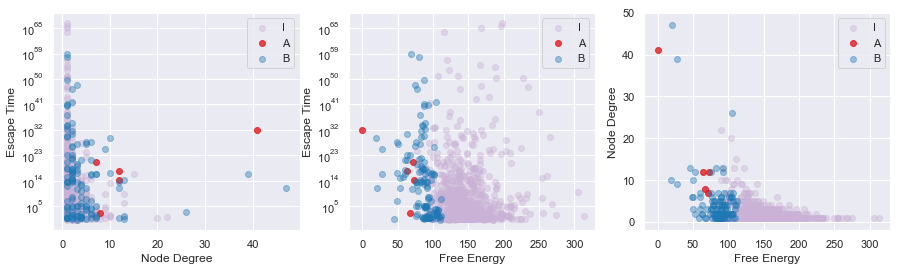

In [20]:
temp = 0.03
rank_nodes_to_eliminate(1.0/temp)

* It's interesting that almost half the nodes only have 1 connection (which mean it can't lie on a reactive pathway). It's worth immediately removing all these nodes and seeing what happens. 
* There appears to be a correlation between node degree and free energy. The least stable states only have 1 connection.
* Interestingly, there isn't a clear correlation between free energy and escape time. I would have thought the lower energy states have larger escape times but the distribution is pretty spread. There are long-lived states that are extremely high energy, but again, these are also the states that only have 1 connection.

Number of nodes with >1 connection: 534
A: 5, B: 128, I: 767


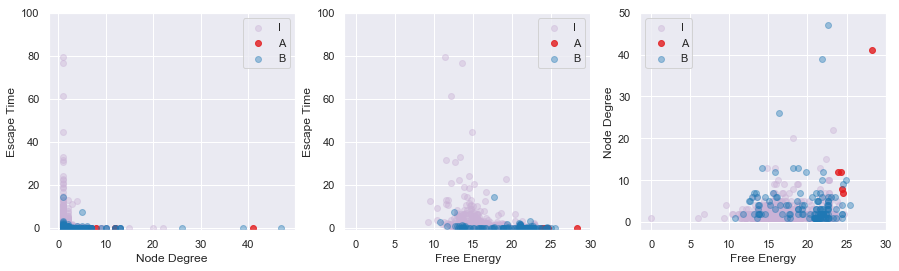

In [27]:
#look at the trends at a higher temperature
temp = 2.0
rank_nodes_to_eliminate(1.0/temp, escape_time_upper_bound=100)

* The trends of the right two plots seem to have reversed. Now the A states have the highest free energy, and the low-free-energy "stable" states have smaller node degrees.
* Similarly, lower free energy states have higher escape times at this higher temperature.
* But notice that at beta = 0.5, the system is not in the arrhenius regime

N,N_TS: 4000 2653
Number of nodes with >1 connection: 534
A: 5, B: 128, I: 767


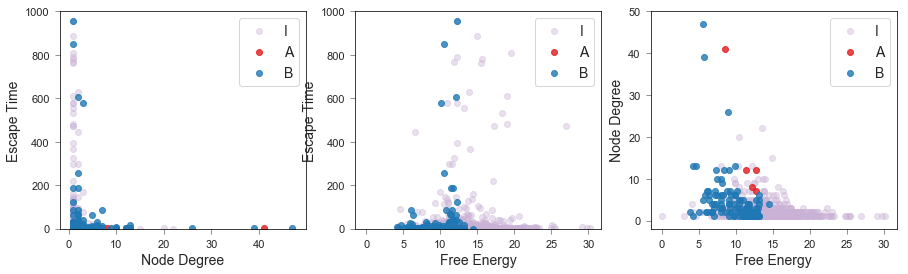

In [143]:
#intermediate temperature
rank_nodes_to_eliminate(4.)

## Try Eliminating All Nodes with < 2 connections

In [125]:
def prune_by_node_degree(beta, dopdf=False):
    Nmax = None
    data_path = "KTN_data/LJ38/4k"
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=Nmax,screen=False)
    node_degree = B.indptr[1:] - B.indptr[:-1]
    D = np.ravel(K.sum(axis=0))
    BF = beta*u-s
    BF -= BF.min()
    AS,BS = kio.load_AB(data_path,index_sel)    
    IS = np.zeros(N, bool)
    IS[~(AS+BS)] = True
    
    """ First calculate p(t), <tau>, <tau^2> without any GT"""
    
    #<tauAB>, <tau^2AB>, <tauBA>, <tau^2BA>
    tau = np.zeros(4)
    if dopdf:
        # time*tau_range, p(t), p(t)_gt (first 3: A->B, second 3: B->A)
        pt = np.zeros((6,400))
        
    #A -> B
    rho = np.exp(-BF) * AS
    rho /= rho.sum()
    Q = (diags(D)-K)[~BS,:][:,~BS]
    x = spsolve(Q,rho[~BS])
    y = spsolve(Q,x)
    tau[0] = x.sum()
    tau[1] = 2.0*y.sum()
    if dopdf:
        pt[0] = np.logspace(-6,3,pt.shape[1])*tau[0]
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~BS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
    
    #B -> A
    rho = np.exp(-BF) * BS
    rho /= rho.sum()
    Q = (diags(D)-K)[~AS,:][:,~AS]
    x = spsolve(Q,rho[~AS])
    y = spsolve(Q,x)
    tau[2] = x.sum()
    tau[3] = 2.0*y.sum()
    if dopdf:
        pt[3] = np.logspace(-6,3,pt.shape[1])*tau[2]
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~AS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[4] = (v*w*nu)@np.exp(-np.outer(nu,pt[3]))*(v*w/nu).sum()
        
    """Now calculate <tau>, <tau^2>, p(t) after graph transforming away all nodes with <2 connections"""
    
    rm_reg = np.zeros(N,bool)
    rm_reg[node_degree < 2] = True
    #free energies of retained states
    r_BF = BF[~rm_reg]
    print(f'Number of nodes with <2 connections: {rm_reg.sum()}')
    print(f'in A: {rm_reg[AS].sum()}, in B: {rm_reg[BS].sum()}, in I: {rm_reg[IS].sum()}')
    #<tauAB>, <tau^2AB>, <tauBA>, <tau^2BA>
    gttau = np.zeros(4)
    
    #A -> B
    rho = (np.exp(-BF) * AS)[~rm_reg] / (np.exp(-BF) * AS).sum()
    GT_Q = gt.gt_seq(N=N,rm_reg=rm_reg,B=B,D=D,trmb=10,retK=True,Ndense=50,screen=False)[2]
    RBS = BS[~rm_reg]
    Q = GT_Q[:,~RBS][~RBS,:]
    x = spsolve(Q,rho[~RBS])
    y = spsolve(Q,x)
    gttau[0] = x.sum()
    gttau[1] = 2.0*y.sum()
    if dopdf:
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~RBS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[2] = (v*w*nu)@np.exp(-np.outer(nu,pt[0])) * (v*w/nu).sum()
    
    #B -> A
    rho = (np.exp(-BF) * BS)[~rm_reg] / (np.exp(-BF) * BS).sum()
    RAS = AS[~rm_reg]
    Q = GT_Q[:,~RAS][~RAS,:]
    x = spsolve(Q,rho[~RAS])
    y = spsolve(Q,x)
    gttau[2] = x.sum()
    gttau[3] = 2.0*y.sum()
    if dopdf:
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~RAS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[5] = (v*w*nu)@np.exp(-np.outer(nu,pt[3])) * (v*w/nu).sum()
    
    if dopdf:
        return beta,tau,gttau,pt
    else:
        return beta,tau,gttau

In [209]:
data = np.zeros((20,9))
for i,_beta in enumerate(np.linspace(2.5,8.5,20)):
    data[i][0],data[i][1:5],data[i][5:9] = prune_by_node_degree(_beta)
    print(data[i][5]/data[i][1])

N,N_TS: 4000 2653
Number of nodes with <2 connections: 334
in A: 0, in B: 0, in I: 334
0.9999999999999849
N,N_TS: 4000 2653
Number of nodes with <2 connections: 334
in A: 0, in B: 0, in I: 334
0.9999999999999895
N,N_TS: 4000 2653
Number of nodes with <2 connections: 334
in A: 0, in B: 0, in I: 334
1.0000000000000113
N,N_TS: 4000 2653
Number of nodes with <2 connections: 334
in A: 0, in B: 0, in I: 334
1.0000000000000018
N,N_TS: 4000 2653
Number of nodes with <2 connections: 334
in A: 0, in B: 0, in I: 334
1.0000000000000004
N,N_TS: 4000 2653
Number of nodes with <2 connections: 334
in A: 0, in B: 0, in I: 334
1.0000000000000016
N,N_TS: 4000 2653
Number of nodes with <2 connections: 334
in A: 0, in B: 0, in I: 334
1.0000000000000004
N,N_TS: 4000 2653
Number of nodes with <2 connections: 334
in A: 0, in B: 0, in I: 334
1.0000000000000142
N,N_TS: 4000 2653
Number of nodes with <2 connections: 334
in A: 0, in B: 0, in I: 334
1.0000000000000082
N,N_TS: 4000 2653
Number of nodes with <2 conn

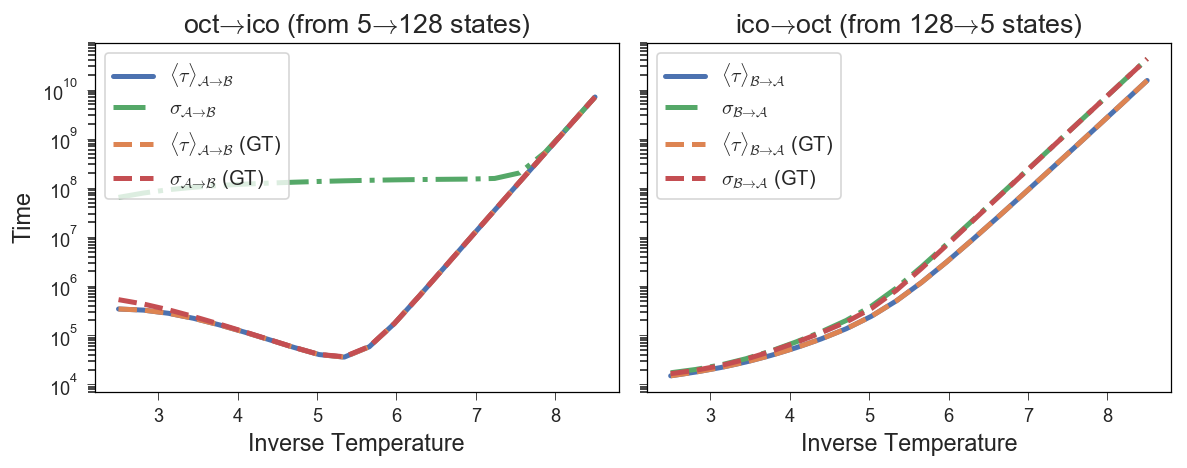

In [210]:
# plot A->B and B->A waiting time 1st and second moments for unprocessed and processed networks
fig,ax = plt.subplots(1,2,figsize=(10,4),dpi=120,sharey=True)
for j in range(2):
    names=['oct','ico']
    size=[5,128]
    ax[j].set_title(r"%s$\to$%s (from %d$\to$%d states)" % (names[j],names[1-j],size[j],size[1-j]))
    names=['A','B']
    ax[j].plot(data[:,0],data[:,1+2*j],'C0-',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$" % (names[j],names[1-j]))
    ax[j].plot(data[:,0],np.sqrt(data[:,2+2*j]-data[:,1+2*j]**2),'C2-.',lw=3,label=r"$\sigma_\mathcal{%s\to{%s}}$" % (names[j],names[1-j]))
    
    ax[j].plot(data[:,0],data[:,5+2*j],'C1--',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$ (GT)" % (names[j],names[1-j]))
    ax[j].plot(data[:,0],np.sqrt(data[:,6+2*j]-data[:,5+2*j]**2),'C3--',lw=3,label=r"$\sigma_\mathcal{%s\to{%s}}$ (GT)" % (names[j],names[1-j]))

    #ax[j].plot(data[:,0],data[:,9+2*j],'C4--',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$ (VGT)" % (names[j],names[1-j]))
    #ax[j].plot(data[:,0],np.sqrt(data[:,10+2*j]-data[:,9+2*j]**2),'C5--',lw=3,label=r"$\sqrt{\langle\tau^2\rangle-\langle\tau\rangle^2}_\mathcal{%s\to{%s}}$ (VGT)" % (names[j],names[1-j]))
    ax[j].set_xlabel("Inverse Temperature")
    if j==0:
        ax[j].set_ylabel("Time")
    ax[j].legend()
    ax[j].set_yscale("log")
plt.tight_layout()

In [211]:
_beta = 1.0/0.25
beta,tau,gttau,pt = prune_by_node_degree(_beta,dopdf=True)

N,N_TS: 4000 2653
Number of nodes with <2 connections: 334
in A: 0, in B: 0, in I: 334


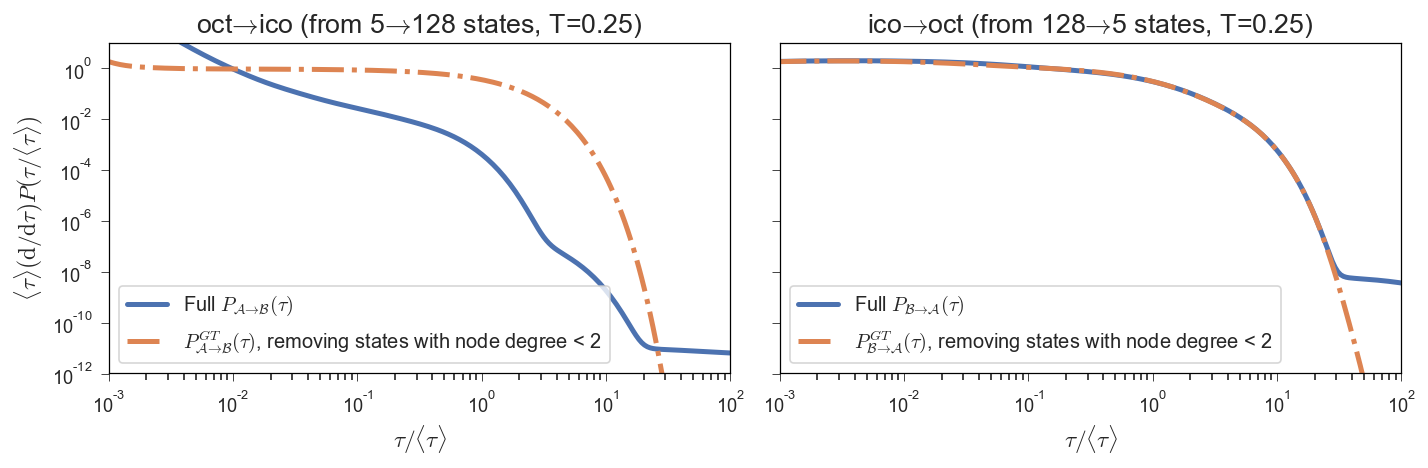

In [212]:
size=[5,128]

fig, ax = plt.subplots(1,2,figsize=(12,4),dpi=120,sharey='row')#,sharex='col')
for j in range(2):
    names=['oct','ico']
    ax[j].set_title(r"%s$\to$%s (from %d$\to$%d states, T=%2.2g)" % (names[j],names[1-j],size[j],size[1-j],1.0/_beta))
    names=["A","B"]

    ax[j].plot(pt[3*j]/tau[2*j],pt[1+3*j],'C0-',lw=3,label=r"Full $P_\mathcal{%s\to{%s}}(\tau)$" % (names[j],names[1-j]))
    ax[j].plot(pt[3*j]/tau[2*j],pt[2+3*j],'C1-.',lw=3,label=r"$P^{GT}_\mathcal{%s\to{%s}}(\tau)$, removing states with node degree < 2" % (names[j],names[1-j]))
    #ax[j].plot(pt[3*j]/tau[2*j],npt[2+3*j],'C2-.',lw=3,label=r"$ P^{GT}_\mathcal{%s\to{%s}}(\tau)$, retaining most stable 10%% in $\mathcal{I}$" % (names[j],names[1-j]))
    
    ax[j].legend()
    ax[j].set_yscale("log")
    ax[j].set_xscale("log")
    ax[j].set_xlim(0.001,100.)
    ax[j].set_xlabel(r"$\tau/\langle\tau\rangle$")
    if j==0:
        ax[j].set_ylabel(r"$\langle\tau\rangle({\rm d}/{\rm d\tau}){P}(\tau/\langle\tau\rangle)$")
    ax[j].set_ylim(pt[1+3*j].min()/10.0,10.0)
plt.tight_layout()


* Clearly, in the A->B direction, removing those 32 nodes in the B region with just 1 connection made a big difference. So blindly removing nodes with <2 connections won't do the trick.

## Try only eliminating just intervening nodes with <2 connections

In [261]:
def prune_intermediate_nodes(beta, dopdf=False, rm_type='escape_time', percent_retained=10):
    Nmax = None
    data_path = "KTN_data/LJ38/4k"
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=Nmax,screen=False)
    node_degree = B.indptr[1:] - B.indptr[:-1]
    D = np.ravel(K.sum(axis=0))
    escape_time = 1./D
    BF = beta*u-s
    BF -= BF.min()
    AS,BS = kio.load_AB(data_path,index_sel)    
    IS = np.zeros(N, bool)
    IS[~(AS+BS)] = True
    
    """ First calculate p(t), <tau>, <tau^2> without any GT"""
    
    #<tauAB>, <tau^2AB>, <tauBA>, <tau^2BA>
    tau = np.zeros(4)
    if dopdf:
        # time*tau_range, p(t), p(t)_gt (first 3: A->B, second 3: B->A)
        pt = np.zeros((6,400))
        
    #A -> B
    rho = np.exp(-BF) * AS
    rho /= rho.sum()
    Q = (diags(D)-K)[~BS,:][:,~BS]
    x = spsolve(Q,rho[~BS])
    y = spsolve(Q,x)
    tau[0] = x.sum()
    tau[1] = 2.0*y.sum()
    if dopdf:
        pt[0] = np.logspace(-6,3,pt.shape[1])*tau[0]
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~BS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
    
    #B -> A
    rho = np.exp(-BF) * BS
    rho /= rho.sum()
    Q = (diags(D)-K)[~AS,:][:,~AS]
    x = spsolve(Q,rho[~AS])
    y = spsolve(Q,x)
    tau[2] = x.sum()
    tau[3] = 2.0*y.sum()
    if dopdf:
        pt[3] = np.logspace(-6,3,pt.shape[1])*tau[2]
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~AS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[4] = (v*w*nu)@np.exp(-np.outer(nu,pt[3]))*(v*w/nu).sum()
        
    """Now calculate <tau>, <tau^2>, p(t) after graph transforming away all nodes with <2 connections"""
    
    rm_reg = np.zeros(N,bool)
    
    if rm_type == 'node_degree':
        rm_reg[node_degree < 2] = True
        rm_reg[(AS+BS)] = False #only remove the intermediate nodes this time

    if rm_type == 'escape_time':
        #remove nodes with the smallest escape times
        #retain nodes in the top percent_retained percentile of escape time
        rm_reg[IS] = escape_time[IS] < np.percentile(escape_time[IS], 100.0 - percent_retained)

    if rm_type == 'free_energy':
        rm_reg[IS] = BF[IS] > np.percentile(BF[IS], percent_retained)
    
    if rm_type == 'hybrid':
        #remove nodes in the top percent_retained percentile of escape time
        time_sel = (escape_time[IS] < np.percentile(escape_time[IS], 100.0 - percent_retained))
        bf_sel = (BF[IS]>np.percentile(BF[IS],percent_retained))
        sel = np.bitwise_and(time_sel, bf_sel)
        #that are also in the lowest percent_retained percentile of free energy
        rm_reg[IS] = sel
        
    #free energies of retained states
    r_BF = BF[~rm_reg]
    print(f'Nodes to eliminate: {rm_reg.sum()}')
    print(f'in A: {rm_reg[AS].sum()}, in B: {rm_reg[BS].sum()}, in I: {rm_reg[IS].sum()}')
    
    #<tauAB>, <tau^2AB>, <tauBA>, <tau^2BA>
    gttau = np.zeros(4)
    
    #A -> B
    rho = (np.exp(-BF) * AS)[~rm_reg] / (np.exp(-BF) * AS).sum()
    GT_Q = gt.gt_seq(N=N,rm_reg=rm_reg,B=B,D=D,trmb=10,retK=True,Ndense=50,screen=False)[2]
    RBS = BS[~rm_reg]
    Q = GT_Q[:,~RBS][~RBS,:]
    x = spsolve(Q,rho[~RBS])
    y = spsolve(Q,x)
    gttau[0] = x.sum()
    gttau[1] = 2.0*y.sum()
    if dopdf:
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~RBS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[2] = (v*w*nu)@np.exp(-np.outer(nu,pt[0])) * (v*w/nu).sum()
    
    #B -> A
    rho = (np.exp(-BF) * BS)[~rm_reg] / (np.exp(-BF) * BS).sum()
    RAS = AS[~rm_reg]
    Q = GT_Q[:,~RAS][~RAS,:]
    x = spsolve(Q,rho[~RAS])
    y = spsolve(Q,x)
    gttau[2] = x.sum()
    gttau[3] = 2.0*y.sum()
    if dopdf:
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~RAS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[5] = (v*w*nu)@np.exp(-np.outer(nu,pt[3])) * (v*w/nu).sum()
    
    if dopdf:
        return beta,tau,gttau,pt
    else:
        return beta,tau,gttau

In [213]:
data = np.zeros((20,9))
for i,_beta in enumerate(np.linspace(2.5,8.5,20)):
    data[i][0],data[i][1:5],data[i][5:9] = prune_intermediate_nodes(_beta, rm_type='node_degree')
    print(data[i][5]/data[i][1])

N,N_TS: 4000 2653
Nodes to eliminate: 334
in A: 0, in B: 0, in I: 334
0.9999999999999849
N,N_TS: 4000 2653
Nodes to eliminate: 334
in A: 0, in B: 0, in I: 334
0.9999999999999895
N,N_TS: 4000 2653
Nodes to eliminate: 334
in A: 0, in B: 0, in I: 334
1.0000000000000113
N,N_TS: 4000 2653
Nodes to eliminate: 334
in A: 0, in B: 0, in I: 334
1.0000000000000018
N,N_TS: 4000 2653
Nodes to eliminate: 334
in A: 0, in B: 0, in I: 334
1.0000000000000004
N,N_TS: 4000 2653
Nodes to eliminate: 334
in A: 0, in B: 0, in I: 334
1.0000000000000016
N,N_TS: 4000 2653
Nodes to eliminate: 334
in A: 0, in B: 0, in I: 334
1.0000000000000004
N,N_TS: 4000 2653
Nodes to eliminate: 334
in A: 0, in B: 0, in I: 334
1.0000000000000142
N,N_TS: 4000 2653
Nodes to eliminate: 334
in A: 0, in B: 0, in I: 334
1.0000000000000082
N,N_TS: 4000 2653
Nodes to eliminate: 334
in A: 0, in B: 0, in I: 334
1.0000000000000095
N,N_TS: 4000 2653
Nodes to eliminate: 334
in A: 0, in B: 0, in I: 334
1.0000000000000002
N,N_TS: 4000 2653
Nod

In [214]:
# plot A->B and B->A waiting time 1st and second moments for unprocessed and processed networks
def plot_AB_waiting_time_moments(data):
    fig,ax = plt.subplots(1,2,figsize=(10,4),dpi=120,sharey=True)
    for j in range(2):
        names=['oct','ico']
        size=[5,128]
        ax[j].set_title(r"%s$\to$%s (from %d$\to$%d states)" % (names[j],names[1-j],size[j],size[1-j]))
        names=['A','B']
        ax[j].plot(data[:,0],data[:,1+2*j],'C0-',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$" % (names[j],names[1-j]))
        ax[j].plot(data[:,0],np.sqrt(data[:,2+2*j]-data[:,1+2*j]**2),'C2-.',lw=3,label=r"$\sigma_\mathcal{%s\to{%s}}$" % (names[j],names[1-j]))

        ax[j].plot(data[:,0],data[:,5+2*j],'C1--',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$ (GT)" % (names[j],names[1-j]))
        ax[j].plot(data[:,0],np.sqrt(data[:,6+2*j]-data[:,5+2*j]**2),'C3--',lw=3,label=r"$\sigma_\mathcal{%s\to{%s}}$ (GT)" % (names[j],names[1-j]))

        #ax[j].plot(data[:,0],data[:,9+2*j],'C4--',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$ (VGT)" % (names[j],names[1-j]))
        #ax[j].plot(data[:,0],np.sqrt(data[:,10+2*j]-data[:,9+2*j]**2),'C5--',lw=3,label=r"$\sqrt{\langle\tau^2\rangle-\langle\tau\rangle^2}_\mathcal{%s\to{%s}}$ (VGT)" % (names[j],names[1-j]))
        ax[j].set_xlabel("Inverse Temperature")
        if j==0:
            ax[j].set_ylabel("Time")
        ax[j].legend()
        ax[j].set_yscale("log")
    plt.tight_layout()

N,N_TS: 4000 2653
Nodes to eliminate: 334
in A: 0, in B: 0, in I: 334


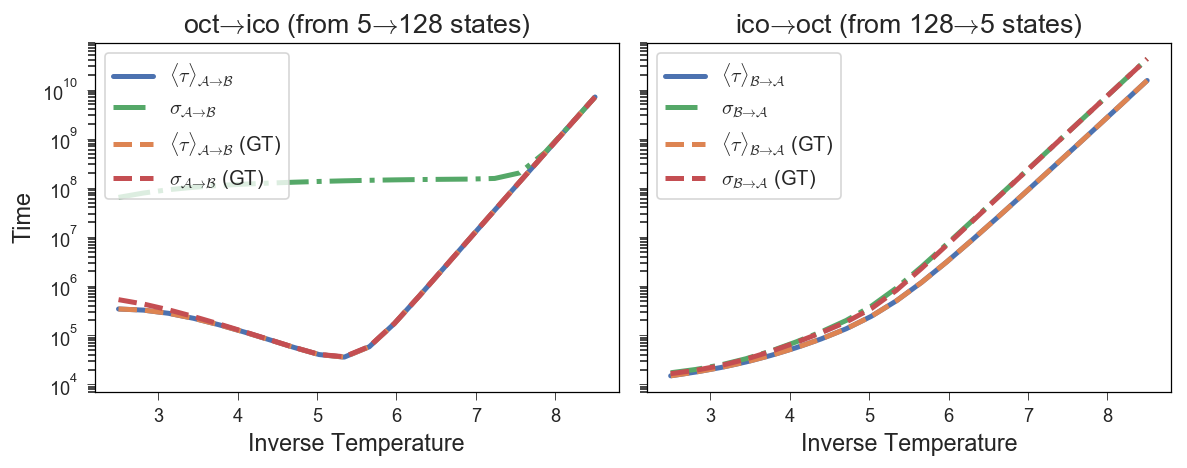

In [215]:
plot_AB_waiting_time_moments(data)
_beta = 1.0/0.25
beta,tau,gttau,pt = prune_intermediate_nodes(_beta, dopdf=True, rm_type='node_degree')

In [219]:
def plot_AB_pdf(beta, tau, gttau, pt, tag='removing nodes with <2 connections'):
    size=[5,128]
    fig, ax = plt.subplots(1,2,figsize=(12,4),dpi=120,sharey='row')#,sharex='col')
    for j in range(2):
        names=['oct','ico']
        ax[j].set_title(r"%s$\to$%s (from %d$\to$%d states, T=%2.2g)" % (names[j],names[1-j],size[j],size[1-j],1.0/_beta))
        names=["A","B"]

        ax[j].plot(pt[3*j]/tau[2*j],pt[1+3*j],'C0-',lw=3,label=r"Full $P_\mathcal{%s\to{%s}}(\tau)$" % (names[j],names[1-j]))
        ax[j].plot(pt[3*j]/tau[2*j],pt[2+3*j],'C1-.',lw=3,label=r"$P^{GT}_\mathcal{%s\to{%s}}(\tau)$, %s" % (names[j],names[1-j], tag))
        #ax[j].plot(pt[3*j]/tau[2*j],npt[2+3*j],'C2-.',lw=3,label=r"$ P^{GT}_\mathcal{%s\to{%s}}(\tau)$, retaining most stable 10%% in $\mathcal{I}$" % (names[j],names[1-j]))

        ax[j].legend()
        ax[j].set_yscale("log")
        ax[j].set_xscale("log")
        ax[j].set_xlim(0.001,100.)
        ax[j].set_xlabel(r"$\tau/\langle\tau\rangle$")
        if j==0:
            ax[j].set_ylabel(r"$\langle\tau\rangle({\rm d}/{\rm d\tau}){P}(\tau/\langle\tau\rangle)$")
        ax[j].set_ylim(pt[1+3*j].min()/10.0,10.0)
    plt.tight_layout()


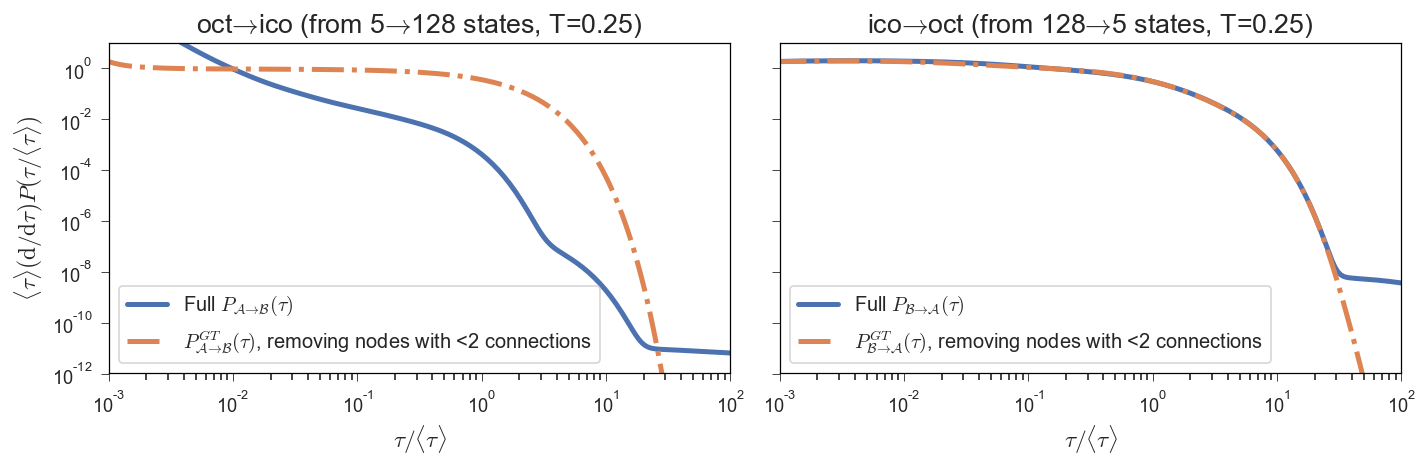

In [220]:
plot_AB_pdf(beta, tau, gttau, pt)

* Actually, looks like keeping all of B didn't help improve the A->B statistics in graph transformed network.
* So the 334 nodes we removed in I were important in the A-> B process

## Try eliminating nodes based on escape time

N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
No

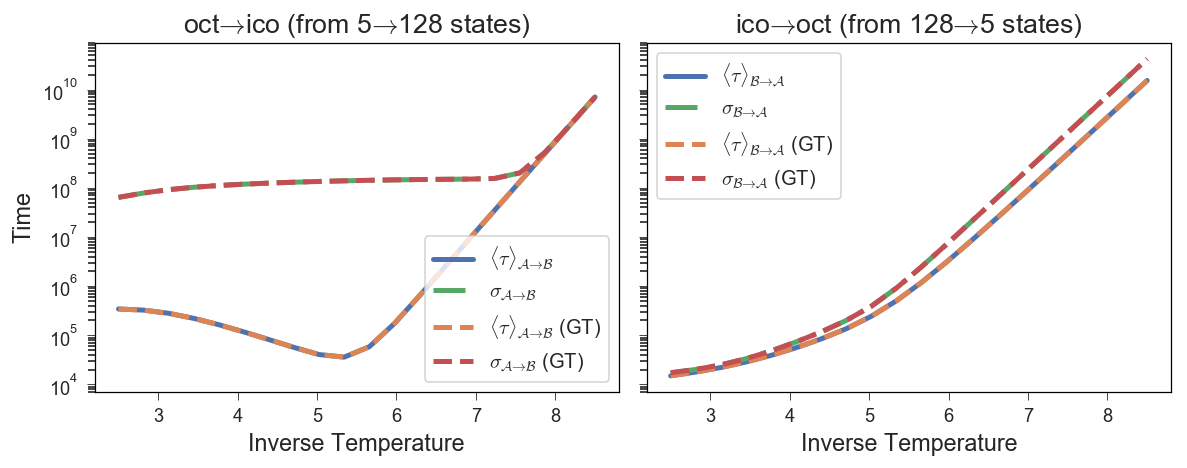

In [221]:
data = np.zeros((20,9))
for i,_beta in enumerate(np.linspace(2.5,8.5,20)):
    data[i][0],data[i][1:5],data[i][5:9] = prune_intermediate_nodes(_beta, rm_type='escape_time', percent_retained=10)

plot_AB_waiting_time_moments(data)

N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690


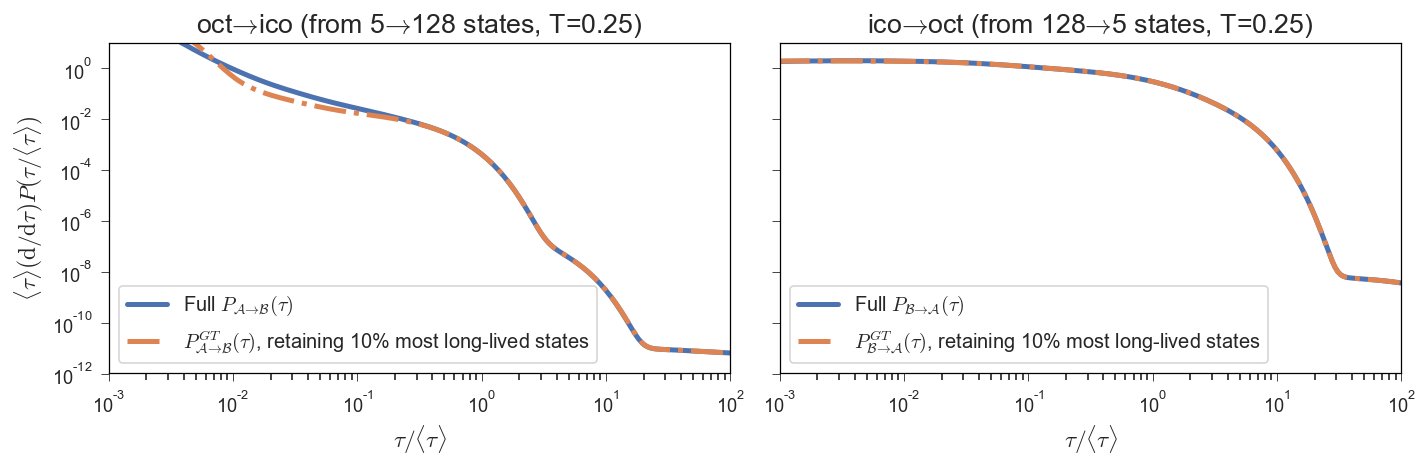

In [239]:
_beta = 1.0/0.25
beta,tau,gttau,pt = prune_intermediate_nodes(_beta, dopdf=True, rm_type='escape_time', percent_retained=10)
plot_AB_pdf(beta, tau, gttau, pt, tag='retaining 10% most long-lived states')

N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690


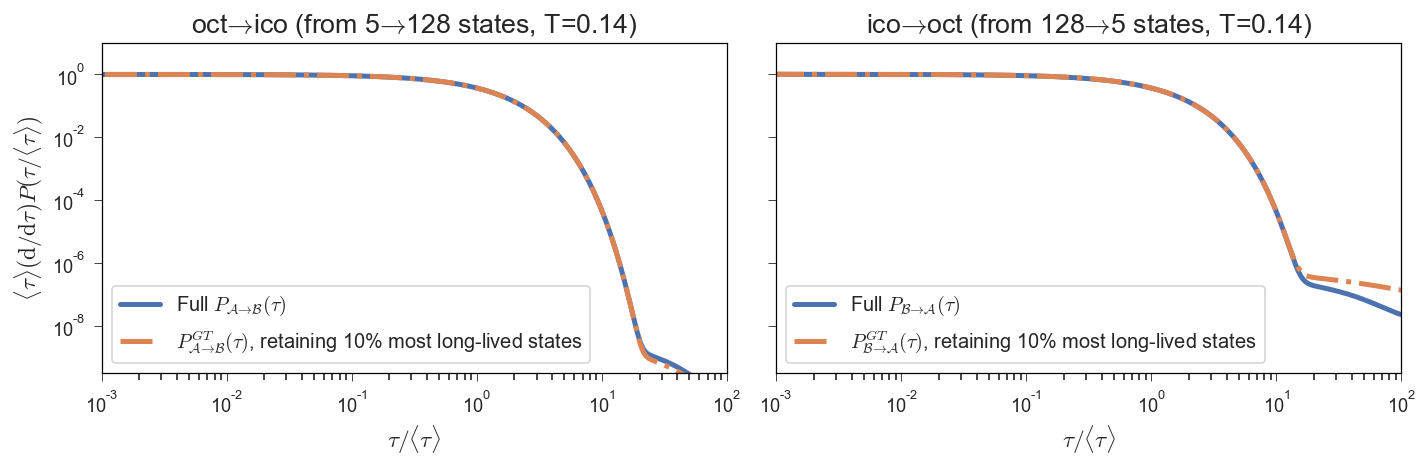

In [223]:
_beta = 7.0
beta,tau,gttau,pt = prune_intermediate_nodes(_beta, dopdf=True, rm_type='escape_time', percent_retained=10)
plot_AB_pdf(beta, tau, gttau, pt, tag='retaining 10% most long-lived states')

## Try eliminating nodes based on Free Energy

N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690
N,N_TS: 4000 2653
No

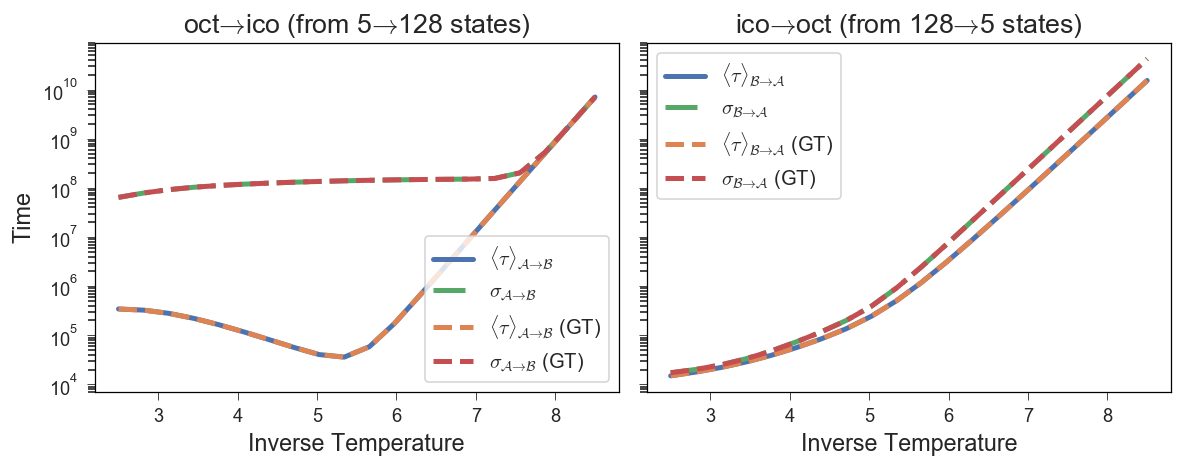

In [224]:
data = np.zeros((20,9))
for i,_beta in enumerate(np.linspace(2.5,8.5,20)):
    data[i][0],data[i][1:5],data[i][5:9] = prune_intermediate_nodes(_beta, rm_type='free_energy', percent_retained=10)

plot_AB_waiting_time_moments(data)

N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690


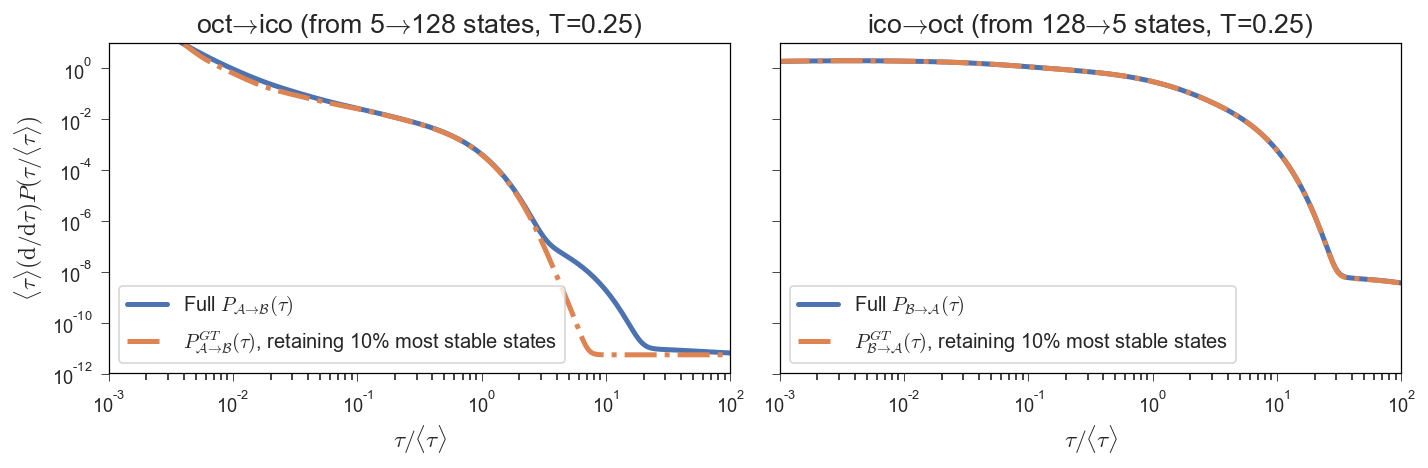

In [225]:
_beta = 1.0/0.25
beta,tau,gttau,pt = prune_intermediate_nodes(_beta, dopdf=True, rm_type='free_energy', percent_retained=10)
plot_AB_pdf(beta, tau, gttau, pt, tag='retaining 10% most stable states')

N,N_TS: 4000 2653
Nodes to eliminate: 690
in A: 0, in B: 0, in I: 690


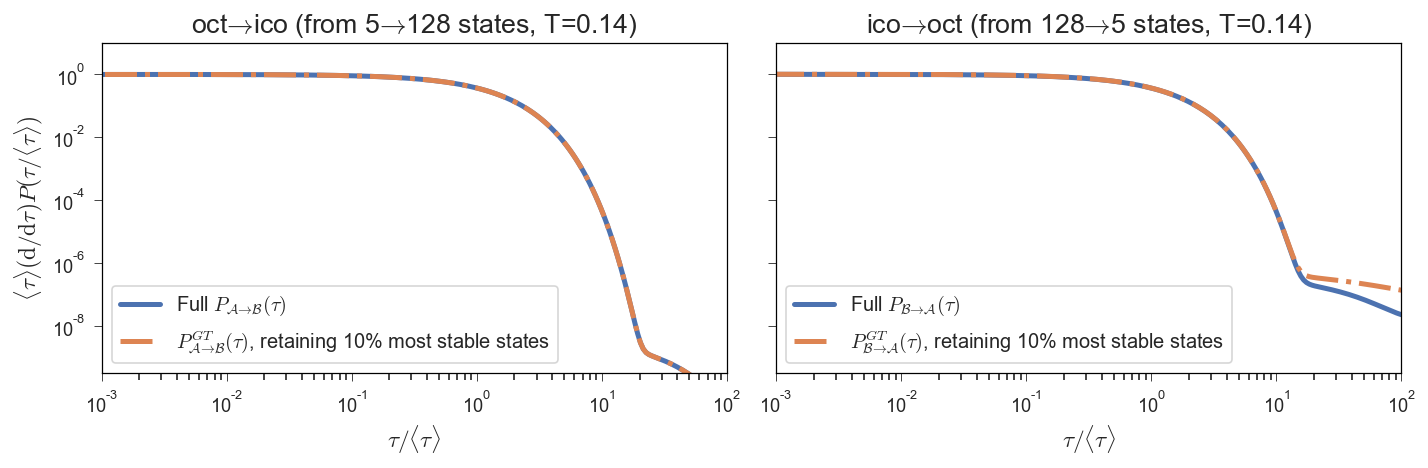

In [226]:
_beta = 7.0
beta,tau,gttau,pt = prune_intermediate_nodes(_beta, dopdf=True, rm_type='free_energy', percent_retained=10)
plot_AB_pdf(beta, tau, gttau, pt, tag='retaining 10% most stable states')

## Hybrid approach: remove high energy states that are short-lived

N,N_TS: 4000 2653
Nodes to eliminate: 650
in A: 0, in B: 0, in I: 650


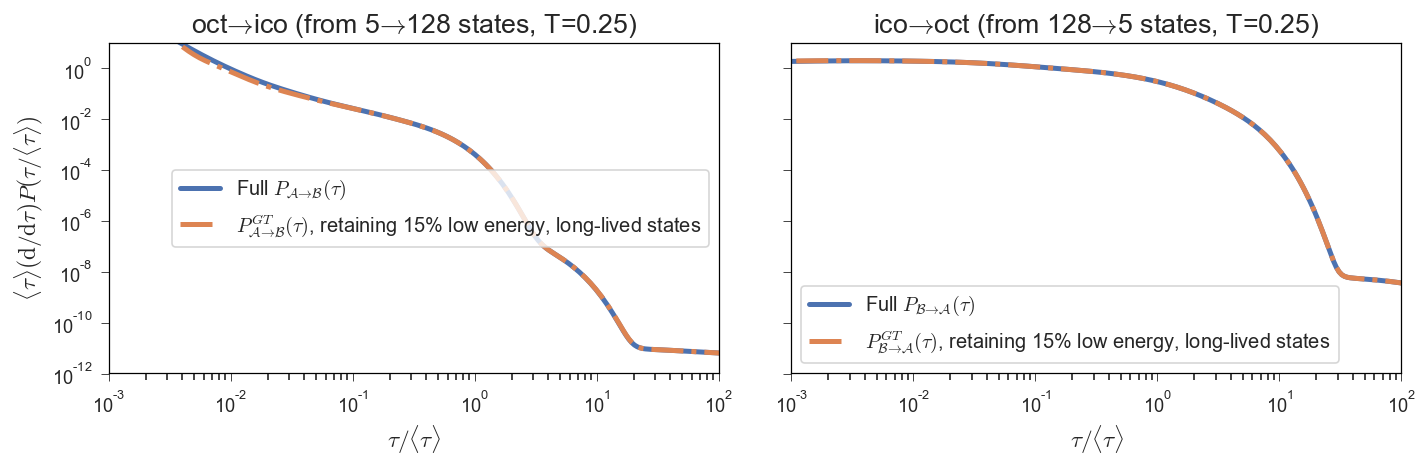

In [268]:
_beta = 1.0/0.25
beta,tau,gttau,pt = prune_intermediate_nodes(_beta, dopdf=True, rm_type='hybrid', percent_retained=8)
plot_AB_pdf(beta, tau, gttau, pt, tag='retaining 15% low energy, long-lived states')

N,N_TS: 4000 2653
Nodes to eliminate: 648
in A: 0, in B: 0, in I: 648


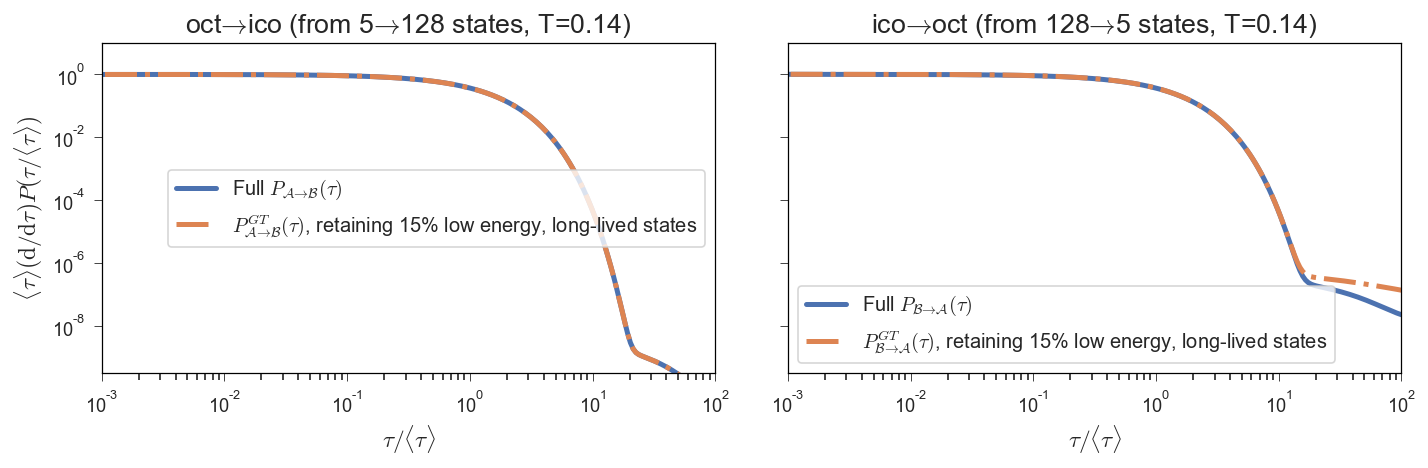

In [272]:
_beta = 7.0
beta,tau,gttau,pt = prune_intermediate_nodes(_beta, dopdf=True, rm_type='hybrid', percent_retained=8)
plot_AB_pdf(beta, tau, gttau, pt, tag='retaining 15% low energy, long-lived states')

# Partial GT on Source Community

In kPS simulations, we want to reduce the size of the active basin while still preserving the waiting time distribution for escape from the basin to the rest of the network. In the following, we will try using the 'escape time' and 'free energy' metrics defined above to remove nodes from the icosohedral (B) region.

In [257]:
#in kPS, we want to simulate escape trajectories from B -> (I U A)
#so in pre-processing the network, we want to be removing states from the source community (in this case B)

def prune_B(beta,percent_retained_in_B=90.,rm_type='free_energy', dopdf=False):
    Nmax = None
    data_path = "KTN_data/LJ38/4k"
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=Nmax,screen=False)
    D = np.ravel(K.sum(axis=0))
    escape_time = 1./D
    BF = beta*u-s
    BF -= BF.min()
    AS,BS = kio.load_AB(data_path,index_sel)
    IS = np.zeros(N, bool)
    IS[~(AS+BS)] = True
    print(f'A: {AS.sum()}, B: {BS.sum()}, I: {IS.sum()}')

    """ First calculate p(t), <tau>, <tau^2> without any GT"""
    
    #<tau_B>, <tau^2_B>
    tau = np.zeros(2)
    if dopdf:
        # time*tau_range, p(t), p(t)_gt (first 3: A->B, second 3: B->A)
        pt = np.zeros((3,400))
    
    #B -> A U I
    rho = np.exp(-BF) * BS
    rho /= rho.sum()
    Q = (diags(D)-K)[BS,:][:,BS]
    x = spsolve(Q,rho[BS])
    y = spsolve(Q,x)
    tau[0] = x.sum()
    tau[1] = 2.0*y.sum()
    if dopdf:
        pt[0] = np.logspace(-6,3,pt.shape[1])*tau[0]
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[BS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
        
    """Now calculate <tau>, <tau^2>, p(t) after graph transforming away the top 10% of B nodes"""
    
    rm_reg = np.zeros(N,bool)
    #rm_reg = ~(AS+BS)
    if rm_type == 'free_energy':
        rm_reg[BS] = BF[BS]>np.percentile(BF[BS],percent_retained_in_B)
    if rm_type == 'escape_time':
        #remove nodes with the smallest escape times
        #retain nodes in the top percent_retained percentile of escape time
        rm_reg[BS] = escape_time[BS] < np.percentile(escape_time[BS], 100.0 - percent_retained_in_B)
    if rm_type == 'hybrid':
        #remove nodes in the top percent_retained percentile of escape time
        time_sel = (escape_time[BS] < np.percentile(escape_time[BS], 100.0 - percent_retained_in_B))
        bf_sel = (BF[BS]>np.percentile(BF[BS],percent_retained_in_B))
        sel = np.bitwise_and(time_sel, bf_sel)
        #that are also in the lowest percent_retained percentile of free energy
        rm_reg[BS] = sel
    #free energies of retained states
    r_BF = BF[~rm_reg]
    print(f'Nodes to eliminate: {rm_reg.sum()}')
    
    #<tau_B>, <tau^2_B>
    gttau = np.zeros(2)

    #B -> A
    rho = (np.exp(-BF) * BS)[~rm_reg] / (np.exp(-BF) * BS).sum()
    RAS = AS[~rm_reg]
    RBS = BS[~rm_reg]
    GT_Q = gt.gt_seq(N=N,rm_reg=rm_reg,B=B,D=D,trmb=10,retK=True,Ndense=50,screen=False)[2]
    Q = GT_Q[:,RBS][RBS,:]
    x = spsolve(Q,rho[RBS])
    y = spsolve(Q,x)
    gttau[0] = x.sum()
    gttau[1] = 2.0*y.sum()
    if dopdf:
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[RBS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[2] = (v*w*nu)@np.exp(-np.outer(nu,pt[0])) * (v*w/nu).sum()
    
    if dopdf:
        return beta,tau,gttau,pt
    else:
        return beta,tau,gttau

## Remove nodes in source community based on escape time

N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96


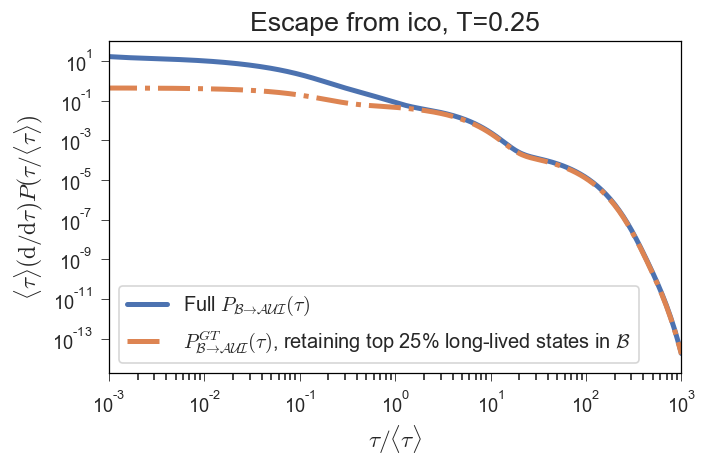

In [230]:
_beta = 1.0/0.25
beta,tau,gttau,pt = prune_B(_beta, percent_retained_in_B=25., rm_type='escape_time', dopdf=True)

def plot_escapeB_pt(beta, tau, gttau, pt, tag='retaining top 25% long-lived states'):
    fig, ax = plt.subplots(figsize=(6,4),dpi=120)#,sharex='col')
    names=['oct','ico']
    ax.set_title(f"Escape from ico, T={(1.0/beta):.2f}")
    names=["AUI","B"]
    ax.plot(pt[0]/tau[0],pt[1],'C0-',lw=3,label=r"Full $P_\mathcal{%s\to{%s}}(\tau)$" % (names[1],names[0]))
    ax.plot(pt[0]/tau[0],pt[2],'C1-.',lw=3,label=r"$P^{GT}_\mathcal{%s\to{%s}}(\tau)$, %s in $\mathcal{B}$" % (names[1],names[0], tag))
    #ax[j].plot(pt[3*j]/tau[2*j],npt[2+3*j],'C2-.',lw=3,label=r"$ P^{GT}_\mathcal{%s\to{%s}}(\tau)$, retaining most stable 10%% in $\mathcal{I}$" % (names[j],names[1-j])) 
    ax.legend()
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlim(0.001,1000.)
    ax.set_xlabel(r"$\tau/\langle\tau\rangle$")
    ax.set_ylabel(r"$\langle\tau\rangle({\rm d}/{\rm d\tau}){P}(\tau/\langle\tau\rangle)$")
    ax.set_ylim(pt[1].min()/10.0,100.0)
    plt.tight_layout()

plot_escapeB_pt(beta, tau, gttau, pt)

N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96


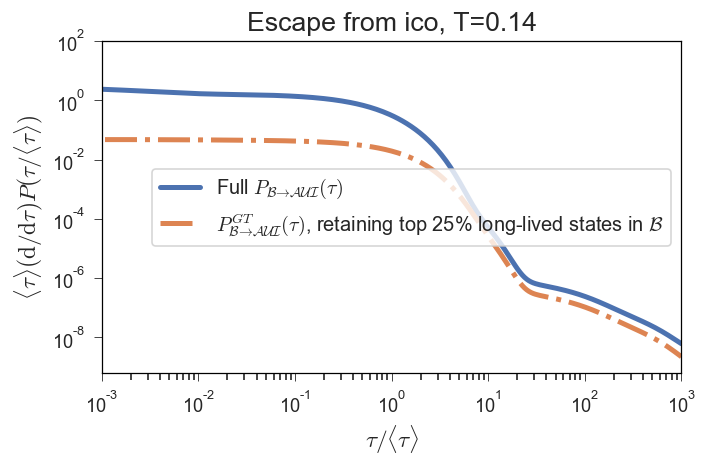

In [231]:
_beta = 7.0
beta,tau,gttau,pt = prune_B(_beta, percent_retained_in_B=25., rm_type='escape_time', dopdf=True)
plot_escapeB_pt(beta, tau, gttau, pt)

In [232]:
data = np.zeros((20,9))
for i,_beta in enumerate(np.linspace(2.5,8.5,20)):
    data[i][0],data[i][1:3],data[i][3:5] = prune_B(_beta, percent_retained_in_B=25., rm_type='escape_time')

N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 

In [233]:
def plot_escapeB_moments(data):
    fig,ax = plt.subplots(figsize=(5,4),dpi=120)
    names=['oct','ico']
    size=[5,128]
    ax.set_title("Escape from iso")
    ax.plot(data[:,0],data[:,1],'C0-',lw=3,label=r"$\langle\tau\rangle_\mathcal{B}$")
    ax.plot(data[:,0],np.sqrt(data[:,2]-data[:,1]**2),'C2-.',lw=3,label=r"$\sigma_\mathcal{B}$")

    ax.plot(data[:,0],data[:,3],'C1--',lw=3,label=r"$\langle\tau\rangle_\mathcal{B}$ (GT)")
    ax.plot(data[:,0],np.sqrt(data[:,4]-data[:,3]**2),'C3--',lw=3,label=r"$\sigma_\mathcal{B}$ (GT)")

        #ax[j].plot(data[:,0],data[:,9+2*j],'C4--',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$ (VGT)" % (names[j],names[1-j]))
        #ax[j].plot(data[:,0],np.sqrt(data[:,10+2*j]-data[:,9+2*j]**2),'C5--',lw=3,label=r"$\sqrt{\langle\tau^2\rangle-\langle\tau\rangle^2}_\mathcal{%s\to{%s}}$ (VGT)" % (names[j],names[1-j]))
    ax.set_xlabel("Inverse Temperature")
    ax.set_ylabel("Time")
    ax.legend()
    ax.set_yscale("log")
    plt.tight_layout()


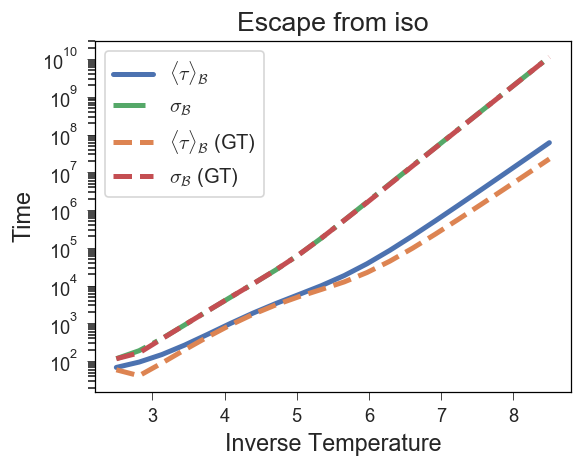

In [234]:
plot_escapeB_moments(data)

## Remove nodes in source community based on free energy

N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96


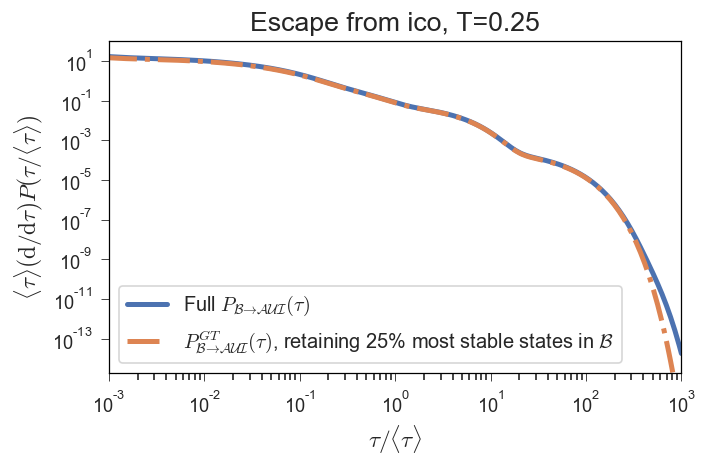

In [235]:
_beta = 1.0/0.25
beta,tau,gttau,pt = prune_B(_beta, percent_retained_in_B=25., rm_type='free_energy', dopdf=True)
plot_escapeB_pt(beta, tau, gttau, pt, tag='retaining 25% most stable states')

N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96


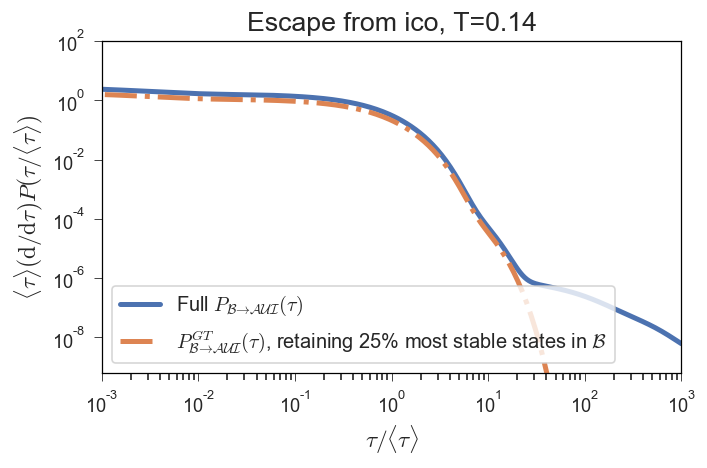

In [237]:
_beta = 7.0
beta,tau,gttau,pt = prune_B(_beta, percent_retained_in_B=25., rm_type='free_energy', dopdf=True)
plot_escapeB_pt(beta, tau, gttau, pt, 'retaining 25% most stable states')

N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 96
N,N_TS: 

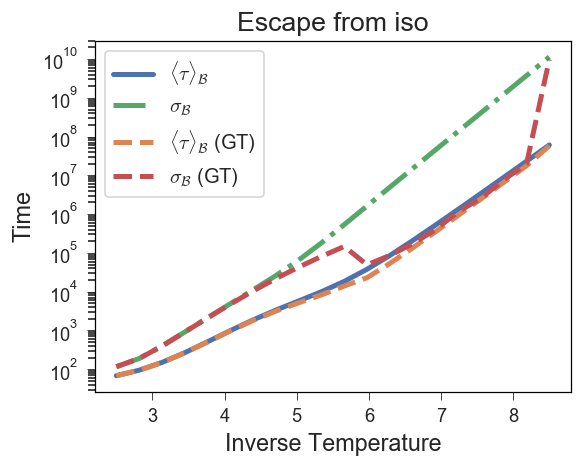

In [236]:
data = np.zeros((20,9))
for i,_beta in enumerate(np.linspace(2.5,8.5,20)):
    data[i][0],data[i][1:3],data[i][3:5] = prune_B(_beta, percent_retained_in_B=25., rm_type='free_energy')
plot_escapeB_moments(data)

* Eliminating nodes with the smallest escape time helps preserve the tails of the waiting time distributions (low probability but long times, aka the rare events), but underestimates the high probability, short escape time, events. 
* Eliminating nodes by free energy has the opposite trend. It gets the high probability short time events correct, but misses the rare events.
* Also, eliminating by free energy gets the second moment wrong at low temperatures and the first moment correct for most temperatures; in contrast, eliminating by escape time gets the second moment correct at all temperatures but systematically underestimates the first moment.

## Hybrid approach: remove high free energy states that are short-lived

N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 97


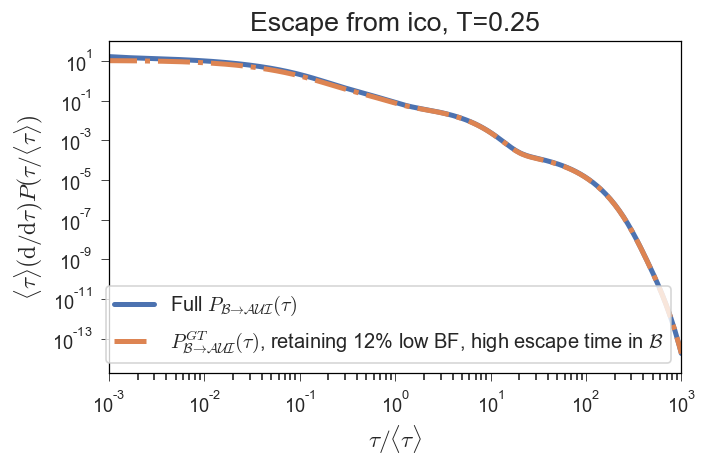

In [274]:
_beta = 1.0/0.25
beta,tau,gttau,pt = prune_B(_beta, percent_retained_in_B=12., rm_type='hybrid', dopdf=True)
plot_escapeB_pt(beta, tau, gttau, pt, tag='retaining 12% low BF, high escape time')

N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 97


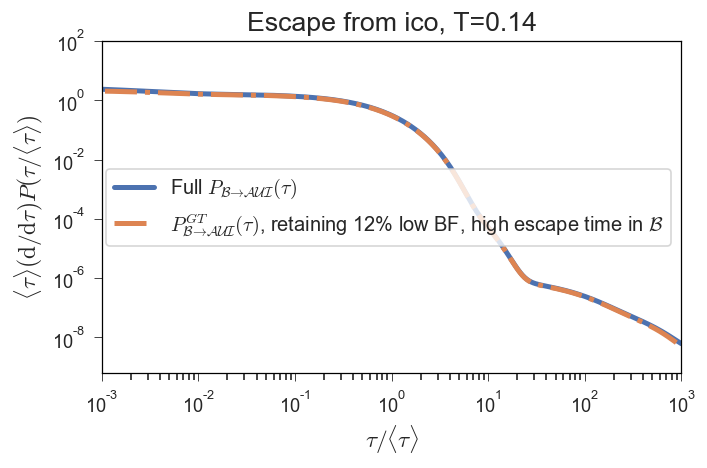

In [273]:
_beta = 7.0
beta,tau,gttau,pt = prune_B(_beta, percent_retained_in_B=12., rm_type='hybrid', dopdf=True)
plot_escapeB_pt(beta, tau, gttau, pt, tag='retaining 12% low BF, high escape time')

N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 98
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 98
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 99
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 98
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 97
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 97
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 97
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 97
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 97
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 97
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 97
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 97
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 97
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 97
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 97
N,N_TS: 4000 2653
A: 5, B: 128, I: 767
Nodes to eliminate: 97
N,N_TS: 

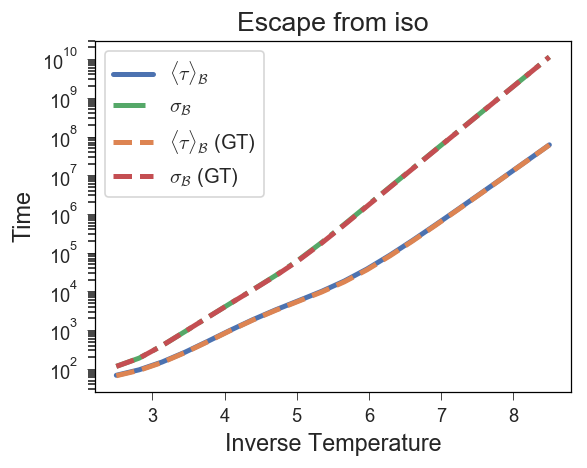

In [258]:
data = np.zeros((20,9))
for i,_beta in enumerate(np.linspace(2.5,8.5,20)):
    data[i][0],data[i][1:3],data[i][3:5] = prune_B(_beta, percent_retained_in_B=12., rm_type='hybrid')
plot_escapeB_moments(data)